### NYC Taxi Trip Duration Prediction — End-to-End ML Project

⸻
## 1) Project Overview

In this notebook, I build an end-to-end machine learning workflow to predict NYC taxi trip duration using spatio-temporal trip records.
The goal is not only to train a model, but also to demonstrate a complete ML pipeline: data loading → cleaning → feature engineering → modeling → evaluation.

Why this project matters:
Trip duration is affected by geography, time patterns (rush hour), traffic, and rider behavior. This makes it a great real-world dataset for practicing feature engineering and model evaluation.

⸻

## 2) Dataset

This project uses the Kaggle dataset NYC Taxi Trip Duration.

Target variable:
	•	trip_duration (in seconds)

Typical input features include:
	•	pickup/dropoff coordinates
	•	pickup datetime
	•	passenger count
	•	vendor_id / store_and_fwd_flag (if available)

⸻

## 3) Workflow Plan (Notebook Roadmap)

This notebook follows a structured process:
	1.	Load & inspect data
	2.	Basic cleaning (types, missing values, duplicates)
	3.	Exploratory Data Analysis (EDA)
	4.	Feature engineering (time + distance + geo patterns)
	5.	Train/Test split
	6.	Model training (baseline → stronger models)
	7.	Evaluation (MAE / RMSE)
	8.	Error analysis & next improvement

## 4) Step 1 — Load Data

First, I load the dataset and inspect the schema, basic statistics, and sample rows.

What I check:
	•	number of rows and columns
	•	data types
	•	missing values
	•	suspicious values (e.g., zero distances, extremely long trips)


In [1]:
import os

print(os.listdir("/kaggle/input"))

['nyc-taxi-bigdata']


In [2]:
import pandas as pd

file_path = "/kaggle/input/nyc-taxi-bigdata/NYC.csv"

df=pd.read_csv(file_path)
df_sample = pd.read_csv(file_path, nrows=100_000)  # فقط 100 هزار تا برای شروع
df_sample.columns.tolist()

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration']

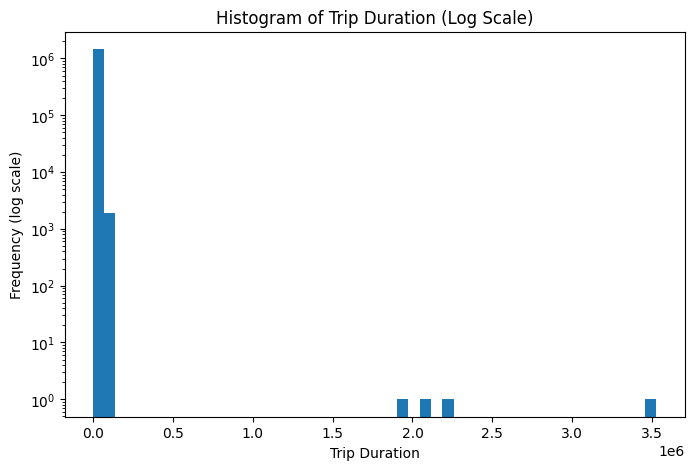

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df["trip_duration"], bins=50)
plt.yscale("log")
plt.xlabel("Trip Duration")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of Trip Duration (Log Scale)")
plt.show()

## 5) Step 2 — Data Cleaning

Before modeling, I apply minimal but necessary cleaning:
	•	convert datetime columns to proper timestamp format
	•	handle missing values (if any)
	•	remove obvious outliers (extreme durations or invalid coordinates)
	•	keep the pipeline reproducible (no manual ad-hoc edits)

Note:
Outlier handling is important in this dataset because a few abnormal trips can distort both training and evaluation.


In [ ]:
import numpy as np
import pandas as pd

def filter_coords(df):
    return df[
           (df["pickup_longitude"] > -75) &
           (df["pickup_longitude"] < -72) &
           (df["dropoff_longitude"] > -75) &
           (df["dropoff_longitude"] < -72) &
           (df["pickup_latitude"] > 40) &
           (df["pickup_latitude"] < 42) &
           (df["dropoff_latitude"] > 40) &
           (df["dropoff_latitude"] < 42) &
           (df["trip_duration"] > 60) &
           (df["trip_duration"] < 20000) &
           (df["speed_kmh"] > .5) &
           (df["speed_kmh"] < 120) &
           (df["distance_km"] > 0.05)
    ]

def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # کیلومتر
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def add_features(df):
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["pickup_minute"]   = df["pickup_datetime"].dt.minute
    df["pickup_hour"]     = df["pickup_datetime"].dt.hour
    df["pickup_dayofweek"] = df["pickup_datetime"].dt.dayofweek
    df["pickup_month"]     = df["pickup_datetime"].dt.month

    df["distance_km"] = haversine(
        df["pickup_longitude"],
        df["pickup_latitude"],
        df["dropoff_longitude"],
        df["dropoff_latitude"],
    )

    df["speed_kmh"] = df["distance_km"] / (df["trip_duration"] / 3600)

    return df

In [ ]:
df=add_features(df)
df_clean = filter_coords(df)

In [ ]:
df_clean.info()
df_clean.describe()
df_clean.shape

In [ ]:
df_model=df_clean.copy()

## 6) Step 3 — Exploratory Data Analysis (EDA)

EDA helps answer:
	•	How is trip_duration distributed? (usually right-skewed)
	•	Are there abnormal trips?
	•	Do trips vary by hour / day of week?
	•	Does distance strongly correlate with duration?

Key plots:
	•	histogram of trip duration
	•	duration by hour of day
	•	duration by day of week
	•	scatter: distance vs duration


In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_model["trip_duration"], bins=50, kde=True)
plt.title("Trip Duration Distribution")
plt.show()

In [ ]:
df_model.columns.tolist()

## 7) Step 4 — Feature Engineering

Feature engineering is the most important part of this project.

7.1 Time-based features

From the pickup timestamp, I create:
	•	pickup_hour
	•	pickup_dayofweek
	•	pickup_month
	•	is_weekend
	•	is_rush_hour (optional)

These features capture traffic patterns and human behavior.

7.2 Distance features

Using pickup/dropoff coordinates, I compute:
	•	Haversine distance (straight-line distance)
	•	optional Manhattan distance approximation

Distance is often the strongest predictive feature.

7.3 Handling skewed target

Trip duration is typically skewed.
To make regression easier, I apply a log transform:
	•	y = log1p(trip_duration)

Later, predictions can be converted back using expm1().

In [ ]:
import numpy as np

df_model["manhattan_km"] = (
    haversine(df_model["pickup_longitude"], df_model["pickup_latitude"],
              df_model["pickup_longitude"], df_model["dropoff_latitude"])
    +
    haversine(df_model["pickup_longitude"], df_model["dropoff_latitude"],
              df_model["dropoff_longitude"], df_model["dropoff_latitude"])
)

df_model["log_distance_km"]   = np.log1p(df_model["distance_km"])

df_model["log_manhattan_km"]  = np.log1p(df_model["manhattan_km"])

p99 = df_model["distance_km"].quantile(0.99)

df_model["distance_km_clip"] = df_model["distance_km"].clip(upper=p99)


df_model["is_weekend"] = (df_model["pickup_dayofweek"] >= 5).astype(int)
df_model["rush_hour"] = df_model["pickup_hour"].isin([7,8,9,16,17,18,19]).astype(int)
df_model["rush_intensity"] = (
    (df_model["pickup_hour"].between(7,10)) * 1 +
    (df_model["pickup_hour"].between(16,19)) * 1
)

df_model["hour_sin"] = np.sin(2*np.pi*df_model["pickup_hour"]/24)
df_model["hour_cos"] = np.cos(2*np.pi*df_model["pickup_hour"]/24)



cols_to_drop = [
    "id",
    "vendor_id",
    "store_and_fwd_flag",
    "pickup_datetime",
    "dropoff_datetime",
    "speed_kmh",        # خود speed ممکنه leakage بسازه
    "passenger_count",  # کمک نمی‌کنه
]

df_model = df_model.drop(columns=cols_to_drop, errors="ignore")

In [ ]:
df_model.columns.tolist()

In [ ]:
from sklearn.cluster import MiniBatchKMeans

def make_clusters(df, n_clusters=100):
    coords_pick = df[["pickup_longitude", "pickup_latitude"]]
    kmeans_pick = MiniBatchKMeans(
        n_clusters=n_clusters, batch_size=20000, n_init="auto"
    ).fit(coords_pick)
    df["pickup_cluster"] = kmeans_pick.predict(coords_pick)

    coords_drop = df[["dropoff_longitude", "dropoff_latitude"]]
    kmeans_drop = MiniBatchKMeans(
        n_clusters=n_clusters, batch_size=20000, n_init="auto"
    ).fit(coords_drop)
    df["dropoff_cluster"] = kmeans_drop.predict(coords_drop)

    return df

df_model = make_clusters(df_model, n_clusters=100)

In [ ]:
def bearing(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    return np.degrees(np.arctan2(x, y))

df_model["bearing"] = bearing(
    df_model["pickup_longitude"], df_model["pickup_latitude"],
    df_model["dropoff_longitude"], df_model["dropoff_latitude"]
)

In [ ]:
df_model["cluster_pair"] = (
    df_model["pickup_cluster"].astype(int) * 1000
    + df_model["dropoff_cluster"].astype(int)
)

In [ ]:
route_stats = (
    df_model
    .groupby("cluster_pair")["trip_duration"]
    .agg(["mean", "median", "count"])
    .reset_index()
)

df_model = df_model.merge(route_stats, on="cluster_pair", how="left")


In [ ]:
df_model.columns.tolist()

In [ ]:
feature_cols = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",

    "pickup_hour",
    "pickup_minute",
    "pickup_dayofweek",
    "pickup_month",

    "distance_km",
    "manhattan_km",

    "is_weekend",
    "rush_hour",
    "rush_intensity",

    "hour_sin",
    "hour_cos",

    "pickup_cluster",
    "dropoff_cluster",
    "cluster_pair",
    
    "bearing",

    "trip_duration"
]
df_model=df_model[feature_cols].copy()

In [ ]:
df_model.columns.tolist()

## 8) Step 5 — Train/Test Split

I split the dataset into train and test sets:
	•	train set for fitting the model
	•	test set for evaluating generalization

This avoids “training on the answers” and gives a realistic performance estimate.


In [ ]:
from sklearn.model_selection import train_test_split

X = df_model.drop(columns=["trip_duration"])
y = df_model["trip_duration"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X.columns.tolist()
#y.head()

In [ ]:
y.describe()
y.quantile([0.01, 0.5, 0.9, 0.99])

In [ ]:
train_df = X_train.copy()
train_df["trip_duration"] = y_train.values

route_stats = (
    train_df.groupby("cluster_pair")["trip_duration"]
    .agg(route_mean_duration="mean",
         route_median_duration="median",
         route_trip_count="count")
    .reset_index()
)

In [ ]:
X_train = X_train.merge(route_stats, on="cluster_pair", how="left")
X_test  = X_test.merge(route_stats, on="cluster_pair", how="left")

In [ ]:
X_train.columns.tolist()

In [ ]:
global_mean = y_train.mean()
global_median = y_train.median()

X_train["route_mean_duration"]   = X_train["route_mean_duration"].fillna(global_mean)
X_test["route_mean_duration"]    = X_test["route_mean_duration"].fillna(global_mean)

X_train["route_median_duration"] = X_train["route_median_duration"].fillna(global_median)
X_test["route_median_duration"]  = X_test["route_median_duration"].fillna(global_median)

X_train["route_trip_count"]      = X_train["route_trip_count"].fillna(0)
X_test["route_trip_count"]       = X_test["route_trip_count"].fillna(0)

In [ ]:
X_train.columns.tolist()

## 9) Step 6 — Modeling

I train models in increasing complexity:

9.1 Baseline model

A simple baseline helps measure improvement.
Examples:
	•	mean predictor (very basic)
	•	linear regression

9.2 Stronger models

Then I try stronger models such as:
	•	Random Forest
	•	Gradient Boosting / XGBoost (if available)

The objective is to balance:
	•	accuracy
	•	robustness
	•	training time
	•	interpretability

⸻

10) Step 7 — Evaluation Metrics

Since this is a regression problem, I evaluate using:
	•	MAE (Mean Absolute Error)
Measures average absolute error in seconds (or in log-space if transformed).
	•	RMSE (Root Mean Squared Error)
Penalizes large errors more strongly than MAE.

I report metrics on:
	•	train set (to check fit)
	•	test set (to check generalization)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.0,
    n_jobs=-1
)


y_train_log = np.log1p(y_train)
model.fit(X_train, y_train_log)

pred_log = model.predict(X_test)
pred_xg = np.expm1(pred_log)

#pred_xg = model.predict(X_test)

mae_xg = mean_absolute_error(y_test, pred_xg)
rmse_xg = np.sqrt(mean_squared_error(y_test, pred_xg))

mae_xg, rmse_xg

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))

mae_lr, rmse_lr

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rf = RandomForestRegressor(
    n_estimators=50,      # به جای 100
    max_depth=20,        # محدودیت عمق
    min_samples_leaf=50, # برگ‌های خیلی ریز نسازه
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))

mae_rf, rmse_rf

In [ ]:
X_train.columns.tolist()

## 11) Step 8 — Error Analysis

After evaluation, I look for patterns in model errors:
	•	Does the model fail on very short trips?
	•	Does it fail on very long trips?
	•	Does performance degrade during rush hours?
	•	Are there location-specific issues?

This step guides improvements.

⸻

## 12) Results Summary

At the end, I summarize:
	•	best-performing model
	•	key features driving performance
	•	what I would improve next (tuning, validation, better geo features)

⸻

## 13) Next Improvements

Possible next steps:
	•	cross-validation instead of a single split
	•	hyperparameter tuning (GridSearch / RandomizedSearch)
	•	better outlier strategy
	•	clustering pickup/dropoff locations
	•	production pipeline (training script + saved model)
